In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC

os.chdir('/content/drive/MyDrive/PR_202210835/Lab10')

In [5]:
import utils

## utils.py 내부 코드가 바뀔때 자동 reload
%load_ext autoreload
%autoreload 2

# LBP 사용하여 표정 인식

In [8]:
from keras.preprocessing.image import load_img, img_to_array

emotion_dictionary = {}

# 데이터셋 로드 함수
def load_dataset(folder):
    images, labels = [], []
    for label, emotion in enumerate(os.listdir(folder)):
        print(f"Loading {emotion} images...")
        emotion_dictionary[label] = emotion ## ##
        for file in os.listdir(os.path.join(folder, emotion)):
            img = load_img(os.path.join(folder, emotion, file), target_size=(64, 64))
            images.append(img_to_array(img))
            labels.append(label)
    return np.array(images), np.array(labels)

# 데이터 로드 및 정규화
images, labels = load_dataset('./emotion')

Loading anger images...
Loading surprise images...
Loading fear images...
Loading sadness images...
Loading happy images...


In [9]:
# LBP 특징 추출 함수
def extract_lbp_features(images, radius=1, n_points=8):
    lbp_features = []
    for img in images:
        '''
        '''                          # LBP 히스토그램 추출
        hist = utils.img2histo_patch(img, n_points)
        lbp_features.append(hist)
    return np.array(lbp_features)

# LBP 특징 추출
lbp_features = extract_lbp_features(images)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(lbp_features, labels, test_size=0.2, random_state=42)

# SVM 분류기 학습
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# 테스트 데이터로 예측 및 결과 출력
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      1.00      0.95        31
           1       1.00      0.94      0.97        51
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        16
           4       1.00      1.00      1.00        36

    accuracy                           0.98       150
   macro avg       0.98      0.99      0.98       150
weighted avg       0.98      0.98      0.98       150



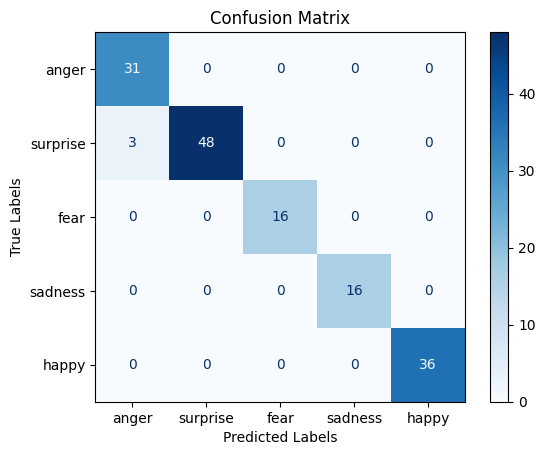

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 라벨 변환
label_names = [emotion_dictionary[i] for i in range(len(emotion_dictionary))]

# Confusion Matrix 생성
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# 딥러닝 모델 기반 1: Train from Scratch

In [11]:
# 데이터 로드
images, labels = load_dataset('./emotion')
# 이미지 정규화
images = images.astype('float32') / 255.0

Loading anger images...
Loading surprise images...
Loading fear images...
Loading sadness images...
Loading happy images...


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# 라벨 생성
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# CNN 기반 모델 정의
model = Sequential([
    # 첫 번째 Convolution + MaxPooling
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),

    # 두 번째 Convolution + MaxPooling

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # 세 번째 Convolution (추가 깊이)
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten + Dense Layers
    Flatten(),
    Dense(128, activation='relu'),  # Fully Connected Layer
    Dense(len(set(labels)), activation='softmax')  # 출력층 (클래스 수에 맞춤)
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
model.fit(X_train, y_train, epochs=10, batch_size=8)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.3682 - loss: 1.4790
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.7657 - loss: 0.5738
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.8404 - loss: 0.3642
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9011 - loss: 0.2340
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.9784 - loss: 0.0804
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9602 - loss: 0.0972
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9891 - loss: 0.0549
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.9950 - loss: 0.0221
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.9913 - loss: 0.0357
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 1.0000 - loss: 0.0067


In [14]:
# 테스트
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# 예측 결과 확인
predictions = model.predict(X_test)
print("Predicted labels:", np.argmax(predictions, axis=1))
print("True labels:",  np.argmax(y_test, axis=1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9790 - loss: 0.2979
Test Accuracy: 98.00%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted labels: [3 1 0 1 1 4 1 1 3 4 0 1 1 4 1 1 0 1 1 3 2 3 2 1 0 4 1 1 1 1 1 3 2 1 4 0 1
 2 0 2 0 4 0 0 4 4 4 3 2 2 0 3 4 1 3 0 3 0 3 0 1 1 4 4 1 1 1 0 2 4 2 2 1 4
 4 2 3 0 1 1 1 0 4 4 0 4 4 3 4 0 4 0 4 4 0 1 3 1 0 1 0 4 0 4 1 0 4 4 2 1 4
 3 1 4 2 4 4 1 4 0 2 0 4 1 4 1 0 4 1 4 1 0 1 1 3 1 1 1 0 4 1 1 4 2 1 3 0 2
 4 0]
True labels: [3 1 0 1 1 4 1 1 3 4 0 1 1 4 1 1 0 1 1 3 2 3 2 1 0 4 1 1 1 1 1 3 2 1 1 0 1
 2 0 2 0 4 0 0 4 4 4 3 2 2 0 3 1 1 3 0 3 0 3 0 1 1 4 4 1 1 1 0 2 4 2 2 1 4
 4 2 3 0 1 1 1 0 4 4 0 1 4 3 4 0 4 0 4 4 0 1 3 1 0 1 0 4 0 4 1 0 4 4 2 1 4
 3 1 4 2 4 4 1 4 0 2 0 4 1 4 1 0 4 1 4 1 0 1 1 3 1 1 1 0 4 1 1 4 2 1 3 0 2
 4 0]


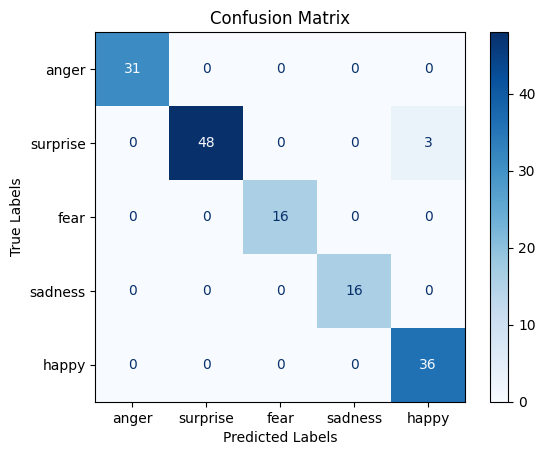

In [15]:
y_pred = np.argmax(predictions, axis=1) # 예측된 레이블
y_true = np.argmax(y_test, axis=1)      # 실제 레이블

# 라벨 변환
label_names = [emotion_dictionary[i] for i in range(len(emotion_dictionary))]

# Confusion Matrix 생성
cm = confusion_matrix(y_true, y_pred)

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# 딥러닝 모델 기반 2: FaceNet의 Embedding Vector 활용

In [16]:
# 필요한 라이브러리 설치
!pip install mtcnn tensorflow keras_facenet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.6 MB/s eta 0:00:00
  Created wheel for keras_facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10368 sha256=cf86b1a79709dc91957b1ddf90d73f7fc08241160dd6ca13aa9b741a159de6c2
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras_facenet


In [17]:
from keras_facenet import FaceNet

# FaceNet 초기화
facenet = FaceNet()

def get_embeddings(facenet, images):
    embeddings = []
    for img in images:
        '''
        '''
        # FaceNet 기반 embedding vector 추출
        embedding = facenet.embeddings(np.expand_dims(img, axis=0))[0]
        embeddings.append(embedding)
    return np.array(embeddings)


In [18]:
# 데이터 로드
images, labels = load_dataset('./emotion')  # 기존 load_dataset 함수 사용
labels = np.array(labels)

# FaceNet 임베딩 추출
'''
'''
embeddings = get_embeddings(facenet, images)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

# 레이블 원-핫 인코딩
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


Loading anger images...
Loading surprise images...
Loading fear images...
Loading sadness images...
Loading happy images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

In [19]:
# 분류 모델 정의
model = Sequential([
  Dense(128, activation='relu', input_shape = (512,)),
  Dense(len(set(labels)), activation='softmax')
]) # Embedding Vector 를 입력으로 사용하는 Fully connected layer 2층의 신경망 모델 생성

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_test, y_test))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4148 - loss: 1.4848 - val_accuracy: 0.6467 - val_loss: 1.0828
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7071 - loss: 0.9771 - val_accuracy: 0.7467 - val_loss: 0.7950
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7900 - loss: 0.7208 - val_accuracy: 0.7800 - val_loss: 0.6634
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8423 - loss: 0.5657 - val_accuracy: 0.8133 - val_loss: 0.5770
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8289 - loss: 0.4958 - val_accuracy: 0.8200 - val_loss: 0.5199
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8932 - loss: 0.4112 - val_accuracy: 0.8000 - val_loss: 0.4878
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9260 - loss: 0.3517 - val_accuracy: 0.8400 - val_loss: 0.4462
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9168 - loss: 0.3099 - val_accuracy: 0.8533 - val_loss: 0.4069
Epo

In [20]:
# 테스트 정확도 확인
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8972 - loss: 0.3594 
Test Accuracy: 90.00%


In [21]:
!jupyter nbconvert --to html Lab10_FER.ipynb

[NbConvertApp] Converting notebook Lab10_FER.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 486006 bytes to Lab10_FER.html
